In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report,f1_score, balanced_accuracy_score

from keras.engine import input_spec
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

from glob import glob

import librosa
import librosa.display
import soundfile
import IPython.display as ipd

from itertools import cycle
sns.set_theme(style = 'white', palette = None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

# First

Load data from drive.

Problem1:

My dataset contains two datasets, one is TESS, another is RAVDESS. 

In [ ]:
raw_data_1 = open('/content/drive/MyDrive/603 project/Toronto emotional speech set (TESS).zip')
!unzip '/content/drive/MyDrive/603 project/Toronto emotional speech set (TESS).zip'
raw_audio_1 = glob('/content/TESS Toronto emotional speech set data/*/*.wav')

In [ ]:
raw_data_2 = open('/content/drive/MyDrive/603 project/RAVDESS Emotional speech audio.zip')
!unzip '/content/drive/MyDrive/603 project/RAVDESS Emotional speech audio.zip'
raw_audio_2 = glob('/content/*/*.wav')

In [ ]:
raw_data_3 = open('/content/drive/MyDrive/603 project/archive.zip')
!unzip '/content/drive/MyDrive/603 project/archive.zip'
raw_audio_3 = glob('/content/AudioWAV/*.wav')

Problem2:

1)Get label values by name of every file.

In [6]:
emotions ={
    'fear': 'Fearful',
    'ps': 'Pleasant_Surprise',
    'sad': 'Sad',
    'angry': 'Angry',
    'disgust': 'Disgust',
    'happy':'Happy',
    'neutral':'Neutral',
    '01':'Neutral',
    # '02':'calm',
    '03':'Happy',
    '04':'Sad',
    '05':'Angry',
    '06':'Fearful',
    '07':'Disgust',
    '08':'Pleasant_Surprise',
    'ANG':'Angry',
    'DIS':'Disgust',
    'FEA':'Fearful',
    'HAP':'Happy',
    'NEU':'Neutral',
    'SAD':'Sad',
}

In [7]:
def getLabel(label1,label2,label3):
  emotion1 = label1[-11:-4]
  emotion2 = label2[24:26]
  emotion3 = label3[27:30]
  for key, value in emotions.items():
    if key in emotion1:
      return value
    elif key in emotion2:
      return value
    elif key in emotion3:
      return value

In [8]:
emotions_label = []
for i in range(len(raw_audio_1)) :
  emotions_label.append(getLabel(raw_audio_1[i], '', ''))
for i in range(len(raw_audio_2)) :
  emotions_label.append(getLabel('', raw_audio_2[i],''))
for i in range(len(raw_audio_3)) :
  emotions_label.append(getLabel('', '', raw_audio_3[i]))

2)Get paths of every audio file

In [9]:
rawData_combine = raw_audio_1 + raw_audio_2 +raw_audio_3
file_name = []
for i in range(len(rawData_combine)) :
  audio = rawData_combine[i]
  file_name.append(audio)

Problem3

Get a dataframe of labels and paths

In [10]:
pd_emotion = pd.DataFrame(emotions_label, columns = ['label'])
pd_emotion['path'] = file_name

# Second
Pre-processing data by the shape of each data wave

Problem1

Display the shape of audio file.

1.5406349206349206

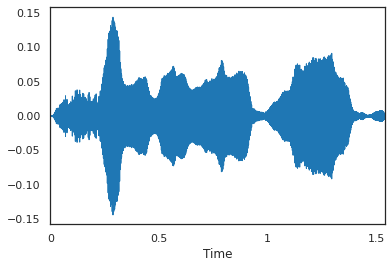

In [11]:
# shape of waves in raw_audio_1
data_1, sample_rate_1 = librosa.load(pd_emotion['path'].iloc[0])
librosa.display.waveplot(data_1,sr = sample_rate_1)
# duration of file in raw_audio_1
librosa.get_duration(data_1,sample_rate_1)

3.603628117913832

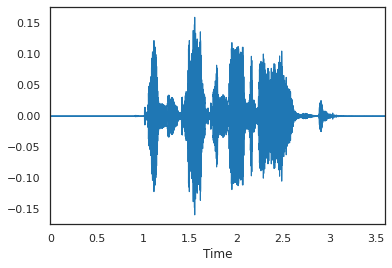

In [12]:
# shape of waves in raw_audio_2
data_2, sample_rate_2 = librosa.load(pd_emotion['path'].iloc[2802])
librosa.display.waveplot(data_2,sr = sample_rate_2)
librosa.get_duration(data_2,sample_rate_2)

Problem2

By the displays above, I can see the second dataset's file has two low decibel parts in the front and end, those doesn't show emotions. So I will trim them.

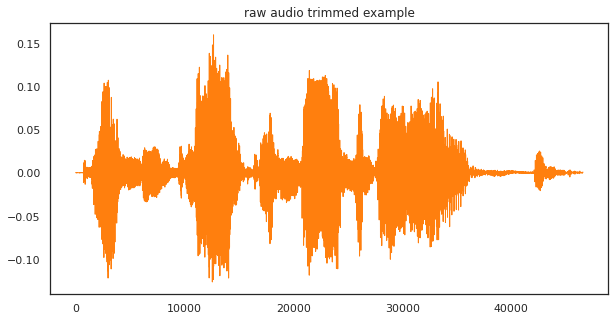

2.1130158730158732

In [13]:
# trimmed example
y_trimmed, _ = librosa.effects.trim(data_2, top_db = 35)
pd.Series(y_trimmed).plot(figsize = (10,5), lw=1,
                  title = 'raw audio trimmed example',
                  color = color_pal[1])
plt.show()
librosa.get_duration(y_trimmed,sample_rate_2)

3.3700226757369616

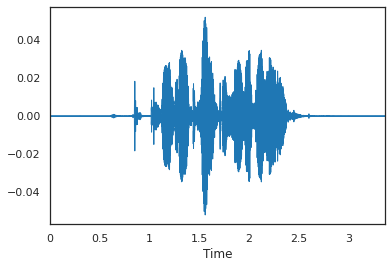

In [14]:
data_2, sample_rate_2 = librosa.load('/content/Actor_18/03-01-08-01-01-01-18.wav')
librosa.display.waveplot(data_2,sr = sample_rate_2)
librosa.get_duration(data_2,sample_rate_2)

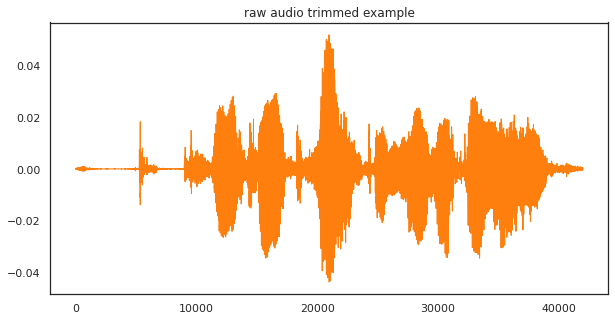

In [15]:
y_trimmed, _ = librosa.effects.trim(data_2, top_db = 35)
pd.Series(y_trimmed).plot(figsize = (10,5), lw=1,
                  title = 'raw audio trimmed example',
                  color = color_pal[1])
plt.show()

Problem4:process .wav files, and extract features for each audio files

In [34]:
def extract_feature(data, sample_rate, mfcc, chroma, mel):
  if chroma:
    stft = np.abs(librosa.stft(data))
    result = np.array([])
  if mfcc:
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr = sample_rate,n_mfcc = 40).T, axis = 0)
    result = np.hstack((result,mfccs))
  if chroma:
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
  if mel:
    mel = np.mean(librosa.feature.melspectrogram(data, sr=sample_rate).T,axis=0)
    result = np.hstack((result,mel))
  return result

In [ ]:
audioArray_1 = []
audioArray_2 = []
audioArray_3 = []
for i in range(len(raw_audio_1)):
  data, sample_rate = librosa.load(raw_audio_1[i])
  feature_1 = extract_feature(data,sample_rate,mfcc=True, chroma=True, mel=True)
  audioArray_1.append(feature_1)

for i in range(len(raw_audio_2)):
  data, sample_rate = librosa.load(raw_audio_2[i])
  y_trimmed, _ = librosa.effects.trim(data, top_db = 35)
  if y_trimmed[0] == 0:
    print(raw_audio_2[i])
  feature_2 = extract_feature(data,sample_rate,mfcc=True, chroma=True, mel=True)
  audioArray_2.append(feature_2)

for i in range(len(raw_audio_3)):
  data, sample_rate = librosa.load(raw_audio_3[i])
  y_trimmed, _ = librosa.effects.trim(data, top_db = 35)
  if y_trimmed[0] == 0:
    print(raw_audio_3[i])
  feature_3 = extract_feature(data,sample_rate,mfcc=True, chroma=True, mel=True)
  audioArray_3.append(feature_3)

In [ ]:
df1 = pd.DataFrame(audioArray_1)
df2 = pd.DataFrame(audioArray_2)
df3 = pd.DataFrame(audioArray_3)

In [ ]:
frames = [df1, df2, df3]

final_df = pd.concat(frames, ignore_index= True)
final_df['emotions'] = pd_emotion['label']
df = final_df.copy()
final_df.to_csv('/content/drive/MyDrive/603 project/Final Data.csv')

Problem: process y label from phrases to numbers

In [ ]:
df = df.dropna()

Problem6: Determine whether this data is balanced.

Conclusion: It's almost balanced, it's not a big deal to train a model.

In [ ]:
sns.countplot(df['emotions'])

Problem5: normalize each feature

In [ ]:
X = df.drop('emotions', axis = 1)
sc = StandardScaler()
X = sc.fit_transform(X)

Problem7: Transfer data format to fit model 

In [41]:
X = np.asarray(X)

In [42]:
X1 = np.expand_dims(X, -1)
# X.shape

In [ ]:
ohe = OneHotEncoder()
y = ohe.fit_transform(df[['emotions']])
y = y.toarray()

Problem: Show dataframe and Split data

In [43]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X1, y, test_size= 0.2,shuffle=True,  random_state = 10)
X_train, val_x, y_train, val_y = train_test_split(X, y, test_size= 0.2, shuffle = True, random_state = 10)
# X_train.shape

In [ ]:
# figure out the independence from heatmap
new = pd.DataFrame(X)
new_corr = new.corr(method = 'pearson')
new_corr
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(new_corr, interpolation = 'nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

#Third 
Create LSTM Model

In [80]:
checkpoint_filepath = '/content/drive/MyDrive/603 project'
mdl_save = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

In [108]:
from keras import callbacks
model = Sequential([
    LSTM(256, return_sequences= False, input_shape = (168,1)),
    Dense(128,kernel_initializer='normal' , activation= 'relu'),
    Dropout(0.3),
    Dense(128, kernel_initializer='normal' ,activation= 'relu'),
    Dropout(0.3),
    # Dense(64, kernel_initializer='normal' ,activation= 'relu'),
    # Dropout(0.3),
    Dense(7, activation= 'softmax'),
])

model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy']) #optimizer =tf.keras.optimizers.Adam(learning_rate=0.001)

In [85]:
model.build()

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data=(val_x, val_y), shuffle = True,callbacks=[mdl_save], epochs = 100, batch_size=32)

In [112]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [113]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

72/72 [==============================] - 1s 6ms/step


array([3, 4, 6, ..., 1, 6, 3])

In [114]:
y_check = np.argmax(y_test, axis=1)
y_check

array([0, 1, 6, ..., 1, 1, 2])

In [115]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

matrices

In [116]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [117]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

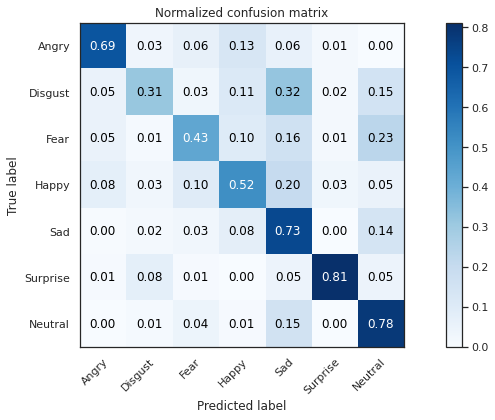

In [118]:
plot_confusion_matrix(y_check, y_pred, emotion_labels, normalize=True, title='Normalized confusion matrix')#emotion_labels,
plt.show()

In [119]:
def performance(test, pred):
  conf_matrix = confusion_matrix(test , pred)
  f1 = f1_score(test , pred)
  accuracy = balanced_accuracy_score(test, pred)
  print('F1 score %s' % f1)
  print('Accuracy %s' % accuracy)

In [128]:
report = classification_report(y_check, y_pred, output_dict=True)
re = pd.DataFrame(report)
#'Angry' 'Disgust' 'Fearful' 'Happy' 'Neutral' 'Pleasant_Surprise' 'Sad'
re = re.rename(columns={'0': 'Angry', '1': 'Disgust','2': 'Fearful','3': 'Happy','4': 'Neutral','5': 'Pleasant_Surprise','6': 'Sad',})
re

,Angry,Disgust,Fearful,Happy,Neutral,Pleasant_Surprise,Sad,accuracy,macro avg,weighted avg
precision,0.805014,0.727273,0.615686,0.545714,0.390374,0.741379,0.573171,0.584856,0.628373,0.627046
recall,0.694712,0.314136,0.431319,0.516216,0.732441,0.811321,0.781163,0.584856,0.611615,0.584856
f1-score,0.745806,0.438757,0.507270,0.530556,0.509302,0.774775,0.661196,0.584856,0.595380,0.579596
support,416.000000,382.000000,364.000000,370.000000,299.000000,106.000000,361.000000,0.584856,2298.000000,2298.000000


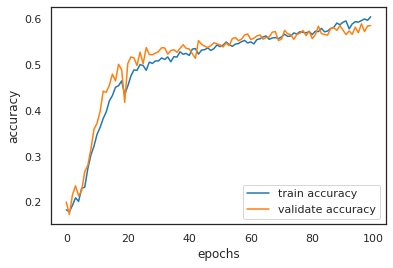

In [121]:
#plot result of acc
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='validate accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

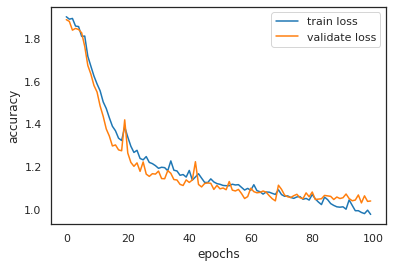

In [122]:
#plot result of loss
epochs = list(range(100))
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='validate loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()